# **Online Payment Fraud Detection using Machine Learning**

**Importando librerias**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive
import plotly.graph_objects as go
#drive.mount('/content/drive')

%matplotlib inline

**Get the Data**

Use pandas to read 'data.csv' as a dataframe called df.

In [11]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

Check out the info(), head(), and describe() methods on data.

# Contexto

Existe una falta de conjuntos de datos públicamente disponibles sobre servicios financieros y especialmente en el ámbito emergente de las transacciones de dinero móvil. Los conjuntos de datos financieros son importantes para muchos investigadores y en particular para nosotros que realizamos investigaciones en el ámbito de la detección de fraudes. Parte del problema es la naturaleza intrínsecamente privada de las transacciones financieras, lo que lleva a la falta de conjuntos de datos públicamente disponibles.

## Explicación de características

- **step**: mapea una unidad de tiempo en el mundo real. En este caso, 1 paso es 1 hora de tiempo. Total de pasos 744 (simulación de 30 días).
- **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT y TRANSFERENCIA.
- **amount**: monto de la transacción en moneda local.
- **nameOrig**: cliente que inició la transacción.
- **oldbalanceOrg**: saldo inicial antes de la transacción.
- **newbalanceOrig**: nuevo saldo después de la transacción.
- **nameDest**: cliente que es el destinatario de la transacción.
- **oldbalanceDest**: saldo inicial del destinatario antes de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).
- **newbalanceDest**: nuevo saldo del destinatario después de la transacción. Tenga en cuenta que no hay información para los clientes que comienzan con M (Comerciantes).
- **isFraud**: Estas son las transacciones realizadas por los agentes fraudulentos dentro de la simulación. En este conjunto de datos específico, el comportamiento fraudulento de los agentes tiene como objetivo obtener ganancias tomando el control de las cuentas de los clientes y tratando de vaciar los fondos transfiriéndolos a otra cuenta y luego retirándolos del sistema.
- **isFlaggedFraud**: El modelo de negocio tiene como objetivo controlar las transferencias masivas de una cuenta a otra y señala intentos ilegales. Un intento ilegal en este conjunto de datos es un intento de transferir más de 200,000 en una sola transacción.


In [12]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


Cambiar nombre de columnas

In [13]:
columns_to_rename = {
    'step': 'TimeStep',
    'type': 'Tipo_Transaccion',
    'amount': 'Cantidad_Transaccion',
    'nameOrig': 'IDCuenta_Origen',
    'oldbalanceOrg': 'Balance_AntesEnvio_Origen',
    'newbalanceOrig': 'Balance_DespuesEnvio_Origen',
    'nameDest': 'IDCuenta_Destino',
    'oldbalanceDest': 'Balance_AntesEnvio_Destino',
    'newbalanceDest': 'Balance_DespuesEnvio_Destino',
    'isFraud': 'EsFraude',
    'isFlaggedFraud': 'EsTransaccionMarcadaFraude'
}

# Renaming the columns
df.rename(columns=columns_to_rename, inplace=True)

# **Exploratory Data Analysis**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   TimeStep                      int64  
 1   Tipo_Transaccion              object 
 2   Cantidad_Transaccion          float64
 3   IDCuenta_Origen               object 
 4   Balance_AntesEnvio_Origen     float64
 5   Balance_DespuesEnvio_Origen   float64
 6   IDCuenta_Destino              object 
 7   Balance_AntesEnvio_Destino    float64
 8   Balance_DespuesEnvio_Destino  float64
 9   EsFraude                      int64  
 10  EsTransaccionMarcadaFraude    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [15]:
df.shape

(6362620, 11)

In [16]:
df.describe()

,TimeStep,Cantidad_Transaccion,Balance_AntesEnvio_Origen,Balance_DespuesEnvio_Origen,Balance_AntesEnvio_Destino,Balance_DespuesEnvio_Destino,EsFraude,EsTransaccionMarcadaFraude
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# **Observaciones Generales de la Función Describe**

## Timing de las Transacciones (TimeStep):
Las transacciones se distribuyen en un rango de tiempo de 1 a 743 unidades (probablemente horas o días). El paso de tiempo promedio es alrededor de 243, lo que sugiere una concentración de actividad de transacciones de rango medio.

## Montos de las Transacciones:
Los montos de las transacciones varían ampliamente, desde 0 hasta aproximadamente 92.45 millones, con una media de aproximadamente 179,861.9. La gran desviación estándar indica una variabilidad significativa en los montos de las transacciones.

## Saldos de Cuentas:
Los saldos de las cuentas del remitente y del destinatario antes y después de las transacciones muestran un amplio rango, lo que indica diversos comportamientos de transacción. Por ejemplo, el saldo máximo del remitente antes de una transacción es de aproximadamente 59.59 millones, y el saldo máximo del destinatario después de una transacción es de aproximadamente 356.18 millones. Las grandes desviaciones estándar sugieren una alta variabilidad en los saldos de las cuentas, lo cual es típico en conjuntos de datos financieros del mundo real.

## Análisis de Fraude

### Transacciones Fraudulentas:
La media de TransacciónFraudulenta está cerca de 0 pero mayor que 0 (aproximadamente 0.0013), lo que indica una proporción muy baja de transacciones fraudulentas. Esto es típico en conjuntos de datos de fraude donde las actividades fraudulentas son relativamente raras en comparación con las transacciones legítimas.

### Transacciones Fraudulentas Marcadas:
La media de TransacciónMarcadaComoFraudulenta está aún más cerca de 0 (aproximadamente 0.0000025), lo que sugiere que muy pocas transacciones son marcadas como fraudulentas. Esto podría implicar criterios estrictos para marcar transacciones como fraudulentas o la rareza de casos de fraude claros.

## Observaciones sobre Distribución y Calidad de los Datos

### Saldos en Cero:
Un número significativo de transacciones involucran cuentas con saldo cero antes y/o después de las transacciones (los cuartiles del 25% para los saldos son 0). Esto podría sugerir un gran número de cuentas nuevas o transitorias, o podría indicar problemas de calidad de datos o tipos específicos de transacciones (por ejemplo, aperturas y cierres de cuentas, o ciertos tipos de transferencias).

### Posibles Valores Atípicos:
Los valores máximos de los montos de las transacciones y los saldos de las cuentas son significativamente más altos que los valores medios y medianos, lo que sugiere la presencia de valores atípicos. Estos valores atípicos podrían representar transacciones grandes pero legítimas, o podrían ser anomalías que necesitan una investigación adicional.

### Distribuciones Sesgadas:
La diferencia entre los valores medios y medianos en los montos de las transacciones y los saldos sugiere distribuciones sesgadas. Por ejemplo, los montos de las transacciones tienen una mediana significativamente más baja que la media, lo que indica una distribución sesgada hacia la derecha con una minoría de transacciones de muy alto valor.


In [17]:
df.isnull().sum()

TimeStep                        0
Tipo_Transaccion                0
Cantidad_Transaccion            0
IDCuenta_Origen                 0
Balance_AntesEnvio_Origen       0
Balance_DespuesEnvio_Origen     0
IDCuenta_Destino                0
Balance_AntesEnvio_Destino      0
Balance_DespuesEnvio_Destino    0
EsFraude                        0
EsTransaccionMarcadaFraude      0
dtype: int64

**There is no null values in dataset**

In [18]:
df.duplicated().sum()

0

No hay valores duplicados

# Separar columnas categoricas y columnas numericas

In [19]:
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if col not in categorical_cols]

In [20]:
numerical_cols

['TimeStep',
 'Cantidad_Transaccion',
 'Balance_AntesEnvio_Origen',
 'Balance_DespuesEnvio_Origen',
 'Balance_AntesEnvio_Destino',
 'Balance_DespuesEnvio_Destino',
 'EsFraude',
 'EsTransaccionMarcadaFraude']

In [21]:
categorical_cols

['Tipo_Transaccion', 'IDCuenta_Origen', 'IDCuenta_Destino']


**Detección de valores atípicos.**

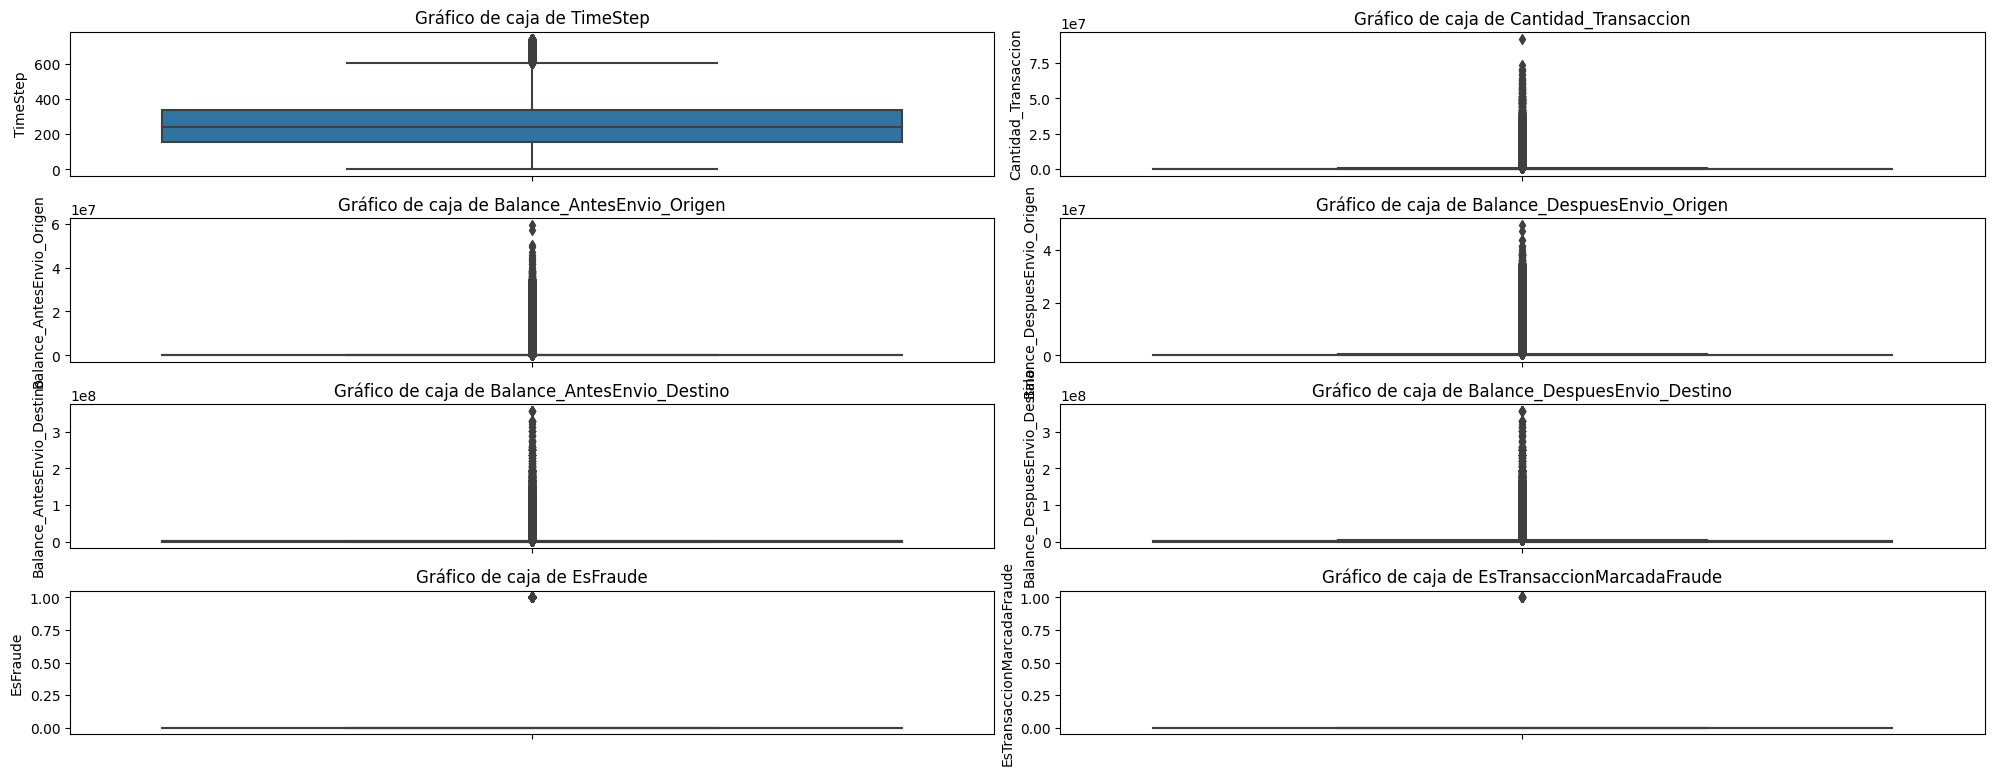

In [22]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Gráfico de caja de {col}')
plt.tight_layout()
plt.show()

Considerando la naturaleza de nuestro conjunto de datos (detección de fraudes), mantener los valores atípicos podría ser crucial ya que podrían representar transacciones fraudulentas. En lugar de eliminarlos, podríamos centrarnos en técnicas que sean robustas a los valores atípicos o diseñadas específicamente para identificar patrones anómalos como potencialmente interesantes o sospechosos. Este enfoque nos permite preservar e incluso resaltar los aspectos más críticos de nuestro conjunto de datos relacionados con la detección de fraudes.


# Data Analysis and Discovering Patterns




En esta sección, nos enfocamos en resumir los datos para descubrir insights ocultos. Realizaremos varios análisis para comprender mejor los datos e identificar cualquier patrón o anomalía subyacente que pueda informar nuestro proceso de toma de decisiones o modelado predictivo.

## Caso 1: Analizar el Monto Total de Transacciones para cada Tipo de Transacción

Este caso de análisis se centra en comprender los montos

In [23]:
total_amount_by_type = df.groupby('Tipo_Transaccion')['Cantidad_Transaccion'].sum().reset_index()
total_amount_by_type['Cantidad_Transaccion_'] = total_amount_by_type['Cantidad_Transaccion'].apply(lambda x: f"{x / 1e9:.2f} mil millones")
total_amount_by_type[['Tipo_Transaccion', 'Cantidad_Transaccion_']]

,Tipo_Transaccion,Cantidad_Transaccion_
0,CASH_IN,236.37 mil millones
1,CASH_OUT,394.41 mil millones
2,DEBIT,0.23 mil millones
3,PAYMENT,28.09 mil millones
4,TRANSFER,485.29 mil millones


In [24]:
fig = go.Figure(data=[go.Pie(labels=total_amount_by_type['Tipo_Transaccion'], values=total_amount_by_type['Cantidad_Transaccion'])])
fig.show()

## Caso 2: Identificar las 10 cuentas con mayor frecuencia de transacciones

Este caso se trata de encontrar las cuentas que son muy activas en términos del número de transacciones.


In [25]:
transaction_count_sender = df['IDCuenta_Origen'].value_counts().reset_index().head(10)
transaction_count_sender.columns = ['IDCuenta_Origen', 'TransactionCount']
transaction_count_sender

,IDCuenta_Origen,TransactionCount
0,C1902386530,3
1,C363736674,3
2,C545315117,3
3,C724452879,3
4,C1784010646,3
5,C1677795071,3
6,C1462946854,3
7,C1999539787,3
8,C2098525306,3
9,C400299098,3


## Caso 3: Detectar Cambios en el Saldo de la Cuenta Después de la Transacción

Comprender cómo cambian los saldos de las cuentas después de las transacciones puede ayudar en la detección de anomalías.


In [26]:
# Calculate the balance change
df['CambioBalanceOrigen'] = df['Balance_AntesEnvio_Origen'] - df['Balance_DespuesEnvio_Origen']

# Identify large changes as those in the top 5% of balance changes
large_changes = df[df['CambioBalanceOrigen'].abs() > df['CambioBalanceOrigen'].quantile(0.95)]

# Selecting and sorting the columns of interest
large_changes = large_changes[['IDCuenta_Origen', 'Balance_AntesEnvio_Origen', 'Balance_DespuesEnvio_Origen', 'CambioBalanceOrigen']].copy()

# Sorting the results by the absolute value of the balance change in descending order for better readability
large_changes = large_changes.sort_values(by='CambioBalanceOrigen', key=abs, ascending=False)

# Formatting the balance and change columns for readability: round the values and add thousands separator
large_changes['Balance_AntesEnvio_Origen'] = large_changes['Balance_AntesEnvio_Origen'].map('${:,.2f}'.format)
large_changes['Balance_DespuesEnvio_Origen'] = large_changes['Balance_DespuesEnvio_Origen'].map('${:,.2f}'.format)
large_changes['CambioBalanceOrigen'] = large_changes['CambioBalanceOrigen'].map('${:,.2f}'.format)

large_changes.reset_index(drop=True, inplace=True)
large_changes.head(10)

,IDCuenta_Origen,Balance_AntesEnvio_Origen,Balance_DespuesEnvio_Origen,CambioBalanceOrigen
0,C671111468,"$37,418,265.31","$27,418,265.31","$10,000,000.00"
1,C794290057,"$42,542,664.27","$32,542,664.27","$10,000,000.00"
2,C1421664654,"$34,892,193.09","$24,892,193.09","$10,000,000.00"
3,C524119157,"$19,228,514.10","$9,228,514.10","$10,000,000.00"
4,C1295280435,"$23,752,520.60","$13,752,520.60","$10,000,000.00"
5,C315155195,"$22,625,132.51","$12,625,132.51","$10,000,000.00"
6,C1074619527,"$19,110,884.44","$9,110,884.44","$10,000,000.00"
7,C292642955,"$23,576,297.10","$13,576,297.10","$10,000,000.00"
8,C1180822515,"$10,000,000.00",$0.00,"$10,000,000.00"
9,C517014062,"$10,000,000.00",$0.00,"$10,000,000.00"


## Caso 4: Análisis de Fraude Basado en el Monto de la Transacción

Este análisis tiene como objetivo determinar si el monto de la transacción está relacionado con actividades fraudulentas.


In [27]:
fraud_amount_stats = df.groupby('EsFraude')['Cantidad_Transaccion'].describe()
fraud_amount_stats

,count,mean,std,min,25%,50%,75%,max
EsFraude,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


## Montos de las Transacciones

Las transacciones fraudulentas tienen promedios y medianas de montos significativamente más altos que las no fraudulentas, lo que sugiere que cuando ocurre fraude, es probable que involucre sumas de dinero más grandes.

## Variabilidad

La desviación estándar es mayor para las transacciones fraudulentas, lo que indica una mayor dispersión en los montos, lo cual podría deberse a la naturaleza variada de las actividades fraudulentas.

## Distribución

La distribución de los montos de las transacciones tanto para transacciones fraudulentas como no fraudulentas está sesgada, con una cola larga de valores más altos, como lo indica el hecho de que la media sea mucho mayor que la mediana en ambos casos.


## Caso 5: Analizar Transacciones Marcadas como Fraudulentas

Este caso investiga las transacciones que han sido marcadas como fraudulentas.


In [28]:
flagged_fraud_transactions = df[df['EsTransaccionMarcadaFraude'] == 1]
flagged_fraud_transactions['Cantidad_Transaccion'] = flagged_fraud_transactions['Cantidad_Transaccion'].map('${:,.2f}'.format)
flagged_fraud_transactions['Balance_AntesEnvio_Origen'] = flagged_fraud_transactions['Balance_AntesEnvio_Origen'].map('${:,.2f}'.format)
flagged_fraud_transactions['Balance_DespuesEnvio_Origen'] = flagged_fraud_transactions['Balance_DespuesEnvio_Origen'].map('${:,.2f}'.format)


flagged_fraud_transactions.head(10)

C:\Users\LAB6K\AppData\Local\Temp\ipykernel_13532\1107591919.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\LAB6K\AppData\Local\Temp\ipykernel_13532\1107591919.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\LAB6K\AppData\Local\Temp\ipykernel_13532\1107591919.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,TimeStep,Tipo_Transaccion,Cantidad_Transaccion,IDCuenta_Origen,Balance_AntesEnvio_Origen,Balance_DespuesEnvio_Origen,IDCuenta_Destino,Balance_AntesEnvio_Destino,Balance_DespuesEnvio_Destino,EsFraude,EsTransaccionMarcadaFraude,CambioBalanceOrigen
2736446,212,TRANSFER,"$4,953,893.08",C728984460,"$4,953,893.08","$4,953,893.08",C639921569,0.0,0.0,1,1,0.0
3247297,250,TRANSFER,"$1,343,002.08",C1100582606,"$1,343,002.08","$1,343,002.08",C1147517658,0.0,0.0,1,1,0.0
3760288,279,TRANSFER,"$536,624.41",C1035541766,"$536,624.41","$536,624.41",C1100697970,0.0,0.0,1,1,0.0
5563713,387,TRANSFER,"$4,892,193.09",C908544136,"$4,892,193.09","$4,892,193.09",C891140444,0.0,0.0,1,1,0.0
5996407,425,TRANSFER,"$10,000,000.00",C689608084,"$19,585,040.37","$19,585,040.37",C1392803603,0.0,0.0,1,1,0.0
5996409,425,TRANSFER,"$9,585,040.37",C452586515,"$19,585,040.37","$19,585,040.37",C1109166882,0.0,0.0,1,1,0.0
6168499,554,TRANSFER,"$3,576,297.10",C193696150,"$3,576,297.10","$3,576,297.10",C484597480,0.0,0.0,1,1,0.0
6205439,586,TRANSFER,"$353,874.22",C1684585475,"$353,874.22","$353,874.22",C1770418982,0.0,0.0,1,1,0.0
6266413,617,TRANSFER,"$2,542,664.27",C786455622,"$2,542,664.27","$2,542,664.27",C661958277,0.0,0.0,1,1,0.0
6281482,646,TRANSFER,"$10,000,000.00",C19004745,"$10,399,045.08","$10,399,045.08",C1806199534,0.0,0.0,1,1,0.0


In [29]:
df.head()

,TimeStep,Tipo_Transaccion,Cantidad_Transaccion,IDCuenta_Origen,Balance_AntesEnvio_Origen,Balance_DespuesEnvio_Origen,IDCuenta_Destino,Balance_AntesEnvio_Destino,Balance_DespuesEnvio_Destino,EsFraude,EsTransaccionMarcadaFraude,CambioBalanceOrigen
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14


## Caso 6: Analizar el Impacto del Monto de la Transacción en la Diferencia de Saldo de la Cuenta

Comprender cómo los montos de las transacciones impactan la diferencia de saldo puede revelar información sobre los comportamientos de las transacciones.


In [30]:
df['CambioBalanceOrigen'] = df['Balance_AntesEnvio_Origen'] - df['Balance_DespuesEnvio_Origen']
df['CambioBalanceDestino'] = df['Balance_AntesEnvio_Destino'] - df['Balance_DespuesEnvio_Destino']

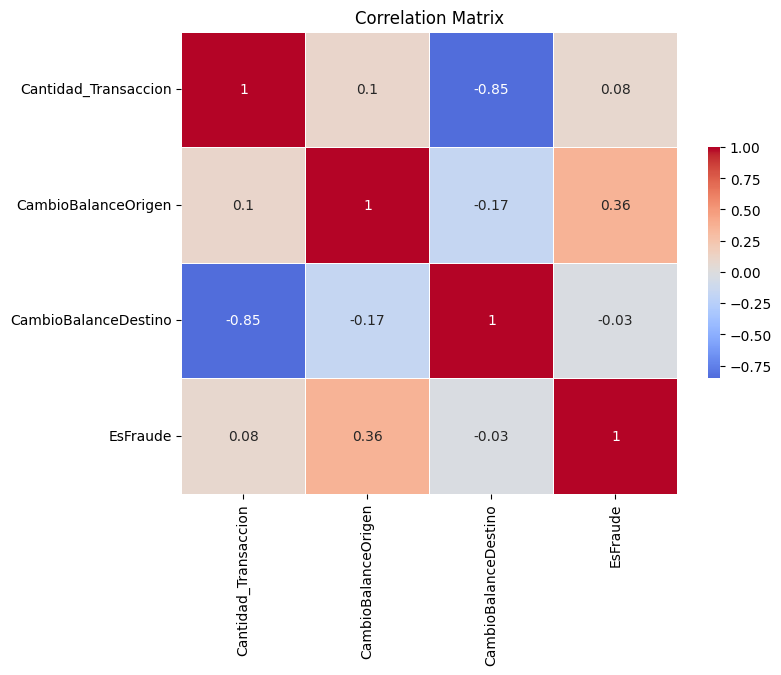

In [31]:
balance_diff_analysis = df[['Cantidad_Transaccion', 'CambioBalanceOrigen', 'CambioBalanceDestino', 'EsFraude']].corr()

balance_diff_analysis_rounded = balance_diff_analysis.round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(balance_diff_analysis_rounded, annot=True, cmap='coolwarm', center=0,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()

## Caso 7: Examinar TimeStep para Detectar Patrones en Transacciones Fraudulentas

Investigar si hay un momento específico en el que las transacciones fraudulentas son más frecuentes.


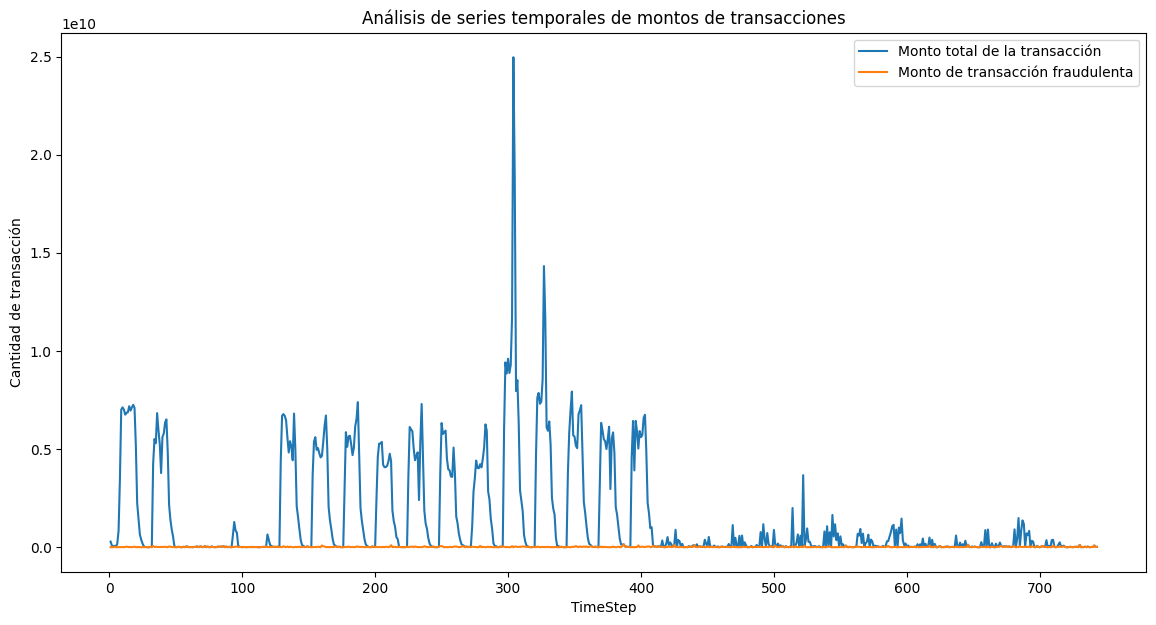

In [32]:
time_series_data = df.groupby('TimeStep').agg(
    TotalAmount=('Cantidad_Transaccion', 'sum'),
    FraudAmount=('Cantidad_Transaccion', lambda x: x[df.loc[x.index, 'EsFraude'] == 1].sum())
).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=time_series_data, x='TimeStep', y='TotalAmount', label='Monto total de la transacción')
sns.lineplot(data=time_series_data, x='TimeStep', y='FraudAmount', label='Monto de transacción fraudulenta')
plt.title('Análisis de series temporales de montos de transacciones')
plt.xlabel('TimeStep')
plt.ylabel('Cantidad de transacción')
plt.legend()
plt.show()

## Caso 8: Distribución de Montos de Transacciones Fraudulentas

Investigar la distribución de los montos de transacciones para transacciones fraudulentas vs. no fraudulentas para ver si las transacciones fraudulentas tienden a ser más grandes o más pequeñas.


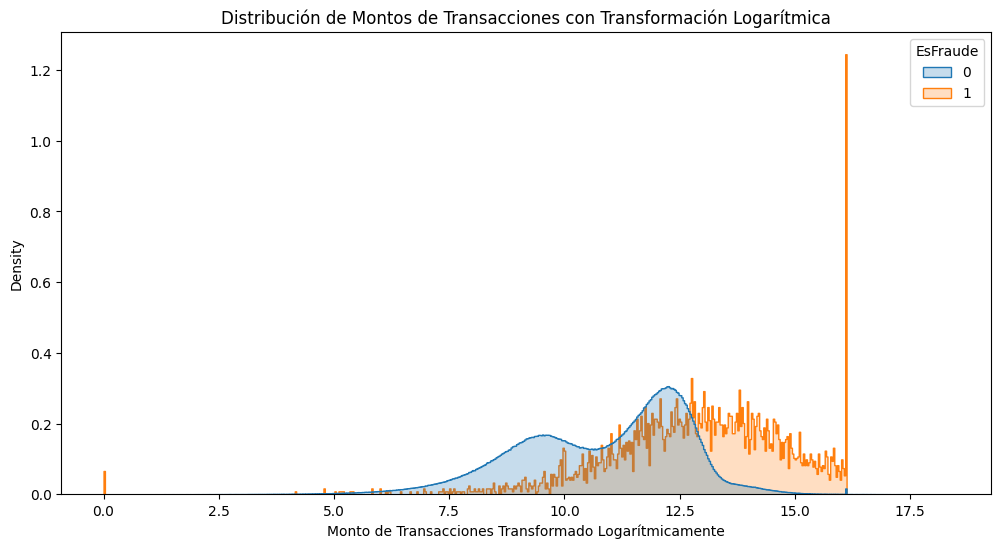

In [33]:
df['RegistroMontoTransaccion'] = np.log(df['Cantidad_Transaccion'] + 1)  # Adding 1 to avoid log(0)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='RegistroMontoTransaccion', hue='EsFraude', element='step', common_norm=False, stat='density')
plt.title('Distribución de Montos de Transacciones con Transformación Logarítmica')
plt.xlabel('Monto de Transacciones Transformado Logarítmicamente')
plt.show()

## Caso 9: Gráfico de Dispersión de Cambios de Saldo

Analizar la relación entre los cambios de saldo en las cuentas del remitente y del destinatario para ver si surgen patrones, especialmente en transacciones fraudulentas.


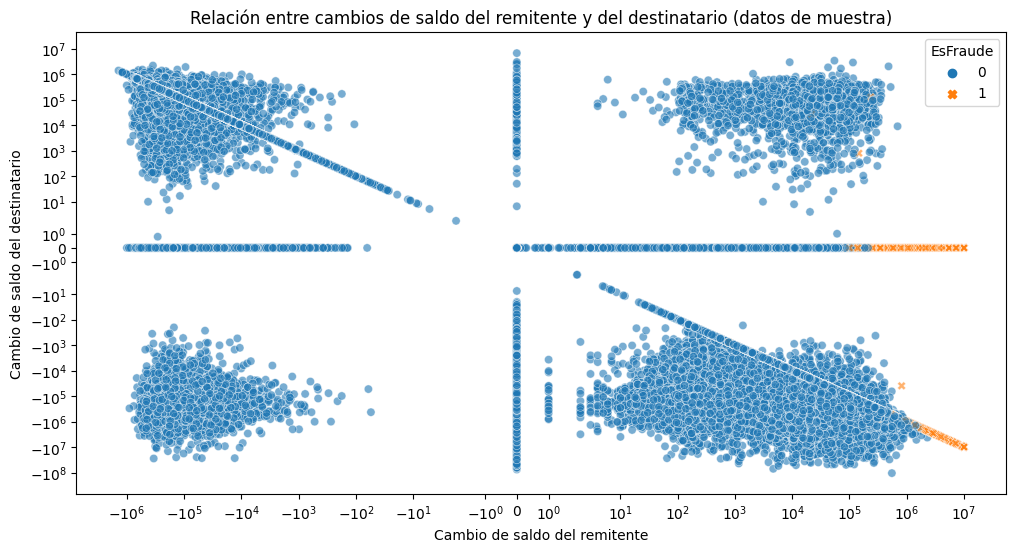

In [34]:
df_sampled = df.sample(frac=0.1, random_state=1)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sampled, x='CambioBalanceOrigen', y='CambioBalanceDestino', hue='EsFraude', style='EsFraude', alpha=0.6)
plt.title('Relación entre cambios de saldo del remitente y del destinatario (datos de muestra)')
plt.xlabel('Cambio de saldo del remitente')
plt.ylabel('Cambio de saldo del destinatario')
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()

# Feature Engineering


1. Codificación Categórica

Tenemos el tipo incluido:

- CASH_IN
- CASH_OUT
- DEBIT
- PAYMENT
- TRANSFER

Por lo tanto, usaremos LabelEncoder.

In [35]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Tipo_Transaccion'] = encoder.fit_transform(df['Tipo_Transaccion'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   TimeStep                      int64  
 1   Tipo_Transaccion              int32  
 2   Cantidad_Transaccion          float64
 3   IDCuenta_Origen               object 
 4   Balance_AntesEnvio_Origen     float64
 5   Balance_DespuesEnvio_Origen   float64
 6   IDCuenta_Destino              object 
 7   Balance_AntesEnvio_Destino    float64
 8   Balance_DespuesEnvio_Destino  float64
 9   EsFraude                      int64  
 10  EsTransaccionMarcadaFraude    int64  
 11  CambioBalanceOrigen           float64
 12  CambioBalanceDestino          float64
 13  RegistroMontoTransaccion      float64
dtypes: float64(8), int32(1), int64(3), object(2)
memory usage: 655.3+ MB


# Eliminar columnas inútiles para el modelo de ML

Se eliminarán las siguientes columnas que no son útiles para el modelo de ML:

- IDCuenta_Origen
- IDCuenta_Destino


In [37]:
df.drop(['IDCuenta_Origen', 'IDCuenta_Destino'], axis=1, inplace=True)

# División de los Datos

Dividiremos los datos en conjuntos de entrenamiento y prueba para entrenar y evaluar nuestro modelo de ML.


In [38]:
X = df[['TimeStep', 'Tipo_Transaccion', 'Cantidad_Transaccion','Balance_AntesEnvio_Origen','Balance_DespuesEnvio_Origen', 'Balance_AntesEnvio_Destino', 'Balance_DespuesEnvio_Destino']]
y = df[['EsFraude']]

In [39]:
len(X), len(y)

(6362620, 6362620)

# Remuestreo de los Datos Desbalanceados

Utilizaremos el método de submuestreo (undersampling) y el metodo de sobremuestreo (oversampling) para abordar el desbalance de clases en nuestro conjunto de datos en 2 casos los cuales son:

**Prototype selection methods:** Los algoritmos de selección de prototipos seleccionarán muestras del conjunto original **S** generando un conjunto de datos donde **|S'| < |S|** y **S' ⊂ S**. En otras palabras, **S'** es un subconjunto de **S**.

**SMOTE**: Es una técnica de sobre-muestreo que genera muestras sintéticas de la clase minoritaria en conjuntos de datos desequilibrados mediante la interpolación de instancias de esa clase.


## Prototype selection methods:

In [40]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=111)

In [42]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_res['EsFraude'].value_counts())])
fig.show()

# Data Standardization

In [43]:
#Standardizing the numerical columns
from sklearn.preprocessing import StandardScaler
col_names= ['Cantidad_Transaccion','Balance_AntesEnvio_Origen','Balance_DespuesEnvio_Origen']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Importando Librerias de ML

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


In [45]:
# Definir los modelos
logreg_cv = LogisticRegression(solver='liblinear', random_state=123)
dt_cv = DecisionTreeClassifier(random_state=123)
knn_cv = KNeighborsClassifier()
rf_cv = RandomForestClassifier(random_state=123)
cv_dict = {0: 'Regresión Logística', 1: 'Árbol de Decisión', 2: 'KNN', 3: 'Random Forest', 4:'Maquina de soporte vectorial'}
cv_models = [logreg_cv, dt_cv, knn_cv, rf_cv]

# Iterar sobre los modelos y calcular las métricas
for i, model in enumerate(cv_models):
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir con el conjunto de prueba
    report = classification_report(y_test, y_pred)  # Calcular el reporte de clasificación
    print(f"--- {cv_dict[i]} ---")
    print(report)

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



--- Regresión Logística ---
              precision    recall  f1-score   support

           0       0.82      0.26      0.39      1632
           1       0.56      0.94      0.71      1654

    accuracy                           0.60      3286
   macro avg       0.69      0.60      0.55      3286
weighted avg       0.69      0.60      0.55      3286

--- Árbol de Decisión ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1632
           1       0.99      1.00      0.99      1654

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

C:\Users\LAB6K\AppData\Local\Temp\ipykernel_13532\152039372.py:11: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



--- KNN ---
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1632
           1       0.83      0.82      0.82      1654

    accuracy                           0.82      3286
   macro avg       0.82      0.82      0.82      3286
weighted avg       0.82      0.82      0.82      3286

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1632
           1       0.99      1.00      0.99      1654

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



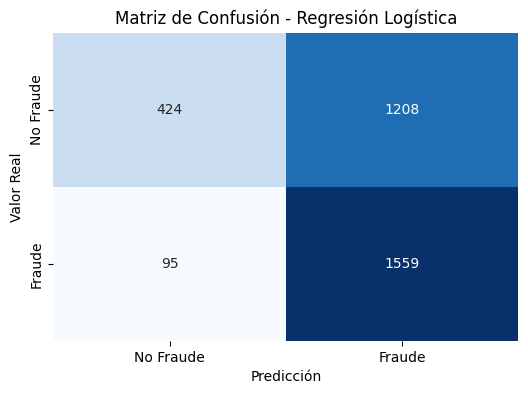

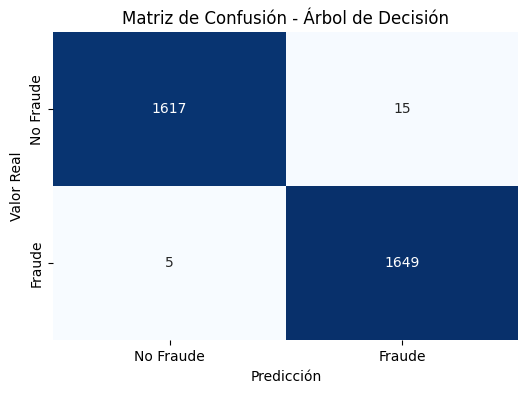

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



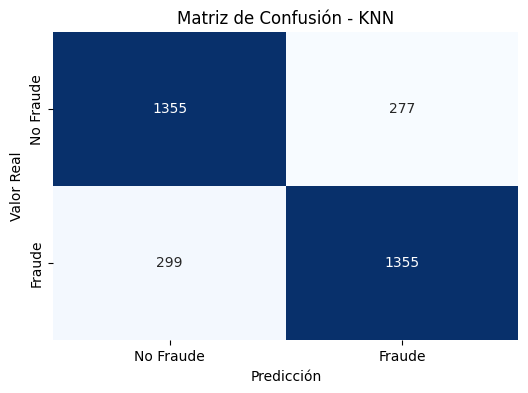

C:\Users\LAB6K\AppData\Local\Temp\ipykernel_13532\3709525557.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



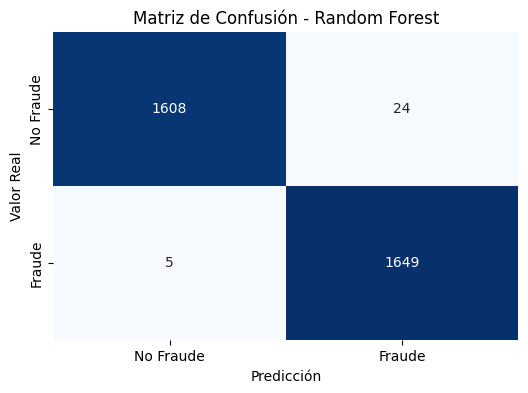

In [46]:
# Iterar sobre los modelos y calcular las matrices de confusión
for i, model in enumerate(cv_models):
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir con el conjunto de prueba
    cm = confusion_matrix(y_test, y_pred)  # Calcular la matriz de confusión
    # Crear un heatmap de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
    plt.title(f"Matriz de Confusión - {cv_dict[i]}")
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

In [47]:
classification_report_imbalanced(y_test, y_pred, target_names=['No Fraude', 'Fraude'])

'                   pre       rec       spe        f1       geo       iba       sup\n\n  No Fraude       1.00      0.99      1.00      0.99      0.99      0.98      1632\n     Fraude       0.99      1.00      0.99      0.99      0.99      0.98      1654\n\navg / total       0.99      0.99      0.99      0.99      0.99      0.98      3286\n'

## SMOTE (Synthetic Minority Over-sampling Technique):

In [48]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=5)
X_res_, y_res_ = sm.fit_resample(X, y)

In [49]:

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_res_, y_res_, test_size=0.2, random_state=0)

In [50]:
len(X_train_), len(X_test_)

(10167051, 2541763)

In [51]:
len(y_train_), len(y_test_)

(10167051, 2541763)

In [52]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_res_['EsFraude'].value_counts())])
fig.show()

In [53]:
# Definir los modelos
logreg_cv = LogisticRegression(solver='liblinear', random_state=123)
dt_cv = DecisionTreeClassifier(random_state=123)
knn_cv = KNeighborsClassifier()
rf_cv = RandomForestClassifier(random_state=123)
cv_dict = {0: 'Regresión Logística', 1: 'Árbol de Decisión', 2: 'KNN', 3: 'Random Forest'}
cv_models = [logreg_cv, dt_cv, knn_cv, rf_cv]

# Iterar sobre los modelos y calcular las métricas
for i, model in enumerate(cv_models):
    model.fit(X_train_, y_train_)  # Entrenar el modelo
    y_pred_ = model.predict(X_test_)  # Predecir con el conjunto de prueba
    report = classification_report(y_test_, y_pred_)  # Calcular el reporte de clasificación
    print(f"--- {cv_dict[i]} ---")
    print(report)

c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- Regresión Logística ---
              precision    recall  f1-score   support

           0       0.93      0.89      0.91   1269605
           1       0.89      0.93      0.91   1272158

    accuracy                           0.91   2541763
   macro avg       0.91      0.91      0.91   2541763
weighted avg       0.91      0.91      0.91   2541763

--- Árbol de Decisión ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1269605
           1       1.00      1.00      1.00   1272158

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763



c:\Users\LAB6K\Desktop\DetectionFraud_Analysis-Detection_ML\.conda\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [ ]:
# Iterar sobre los modelos y calcular las matrices de confusión
for i, model in enumerate(cv_models):
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir con el conjunto de prueba
    cm = confusion_matrix(y_test, y_pred)  # Calcular la matriz de confusión
    # Crear un heatmap de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
    plt.title(f"Matriz de Confusión - {cv_dict[i]}")
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

: 

In [ ]:
classification_report_imbalanced(y_test, y_pred, target_names=['No Fraude', 'Fraude'])

: 

SMOTE es una técnica para aumentar el tamaño de las clases minoritarias mientras se evita el sobreajuste, esto lo logra generando nuevos ejemplos sintéticos cercanos a los demás puntos (pertenecientes a la clase minoritaria) en el espacio de características. A diferencia del submuestreo, que elimina muestras, SMOTE preserva la información al crear datos adicionales, lo que genera mejorar la capacidad del modelo para generalizar de manera efectiva a partir de los datos disponibles.